# Exploring Airbnb listings and pricing in the Greater Montréal Area

In this notebook, we will be answering the following Questions about Airbnb market in Montréal, QC, Canada.

* What is the breakdown of listings by neighbourhood?
* What is the share of private rooms vs entire houses in Montreal?
* What is the average price listing per room type per neighbourhood?
* What is the effect of the season on price listing or in other words how does the prices change over time?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pathlib import Path
import requests 
from IPython.display import display
%matplotlib inline

### download Airbnb dataset from source.
Download the datasets need from source if they are not already there. 

In [2]:
# download data to project folder listings.csv.gz
# This will create a subfolder where this notebook is installed and download the file.

data_src = 'listings.csv.gz'
url= 'http://data.insideairbnb.com/canada/qc/montreal/2020-03-17/data/listings.csv.gz'

def download_url(url, save_path, chunk_size=256):
    """
    Check if file already exists, if not use url to download it.
    Args:
        url(str): URL of the zipped file.
        save_path(str): Path where the file should be saved
        chunk_size(int): Chunk size to iterate over from the streamed request.
    """
    # check if file exists at path or not
    if not Path(save_path).exists():
        r = requests.get(url, stream=True)
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)

# Download from url if file doesn't exist.
download_url(url, data_src)

    
# Display all columns to have an understanding of the feature vectors provided. 
pd.options.display.max_columns = None

### Cleaning up the dataframe. 
Here we will:
* Drop all the columns that are empty
* Remove columns that are deemed unnecessary to answer the above mentioned questions.
* Make sure that the datatypes are in the right type, else update these to make use of the data.

These 2 points could be done as we are answering the questions: 

* Check categorical data and they need to be imputed/dummies be created.
* Deal with missing values in columns in the appropriate way as we are answering the questions.


In [3]:
# Read the compressed csv file to a pandas dataframe. This is in a separate cell as to run it once.
df = pd.read_csv(data_src, compression='gzip', error_bad_lines=False)

# drop empty columns inplace in the same cell and get the names of the dropped columns
num_features_before = set(df.columns)
df.dropna(how='all',axis=1,inplace=True)
num_features_after = set(df.columns)

print(f'Dropped columns are: {(num_features_before - num_features_after)}')

Dropped columns are: {'thumbnail_url', 'neighbourhood_group_cleansed', 'license', 'xl_picture_url', 'medium_url'}


/Users/faisalbarazi/projects/airbnb_mtl_prices/airbnb_mtl_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Explore the dataset a bit
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200317175912,2020-03-18,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,https://a0.muscache.com/im/pictures/88170231/0...,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within an hour,100%,0%,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,Montreal,QC,H2J 3E9,Montreal,"Montreal, Canada",CA,Canada,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Pets live on this prop...",NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,2 weeks ago,t,0,0,0,76,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.36
1,2843,https://www.airbnb.com/rooms/2843,20200317175912,2020-03-18,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,https://a0.muscache.com/im/pictures/397204dc-4...,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscache.com/im/pictures/user/7c04e...,Little Burgundy,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",

In [5]:
# Further clean up the dataframe by droping un-useful data. 
columns_to_drop = [
    'state', 'city', 'neighbourhood', 'street', 'host_picture_url','host_thumbnail_url',
    'host_about', 'host_location','host_url' ,'host_id', 'picture_url','house_rules',
    'access', 'interaction', 'notes', 'neighborhood_overview', 'description', 'space',
    'name','scrape_id', 'listing_url','id','transit','experiences_offered','summary','host_name',
    'host_neighbourhood', 'smart_location','country_code','country','market','amenities',
    'jurisdiction_names','last_scraped','calendar_updated'
]
df.drop(columns=columns_to_drop,axis=1, inplace=True)


In [6]:
# Prices are not in the correct datatype, so we are droping the dollar sign and number separator.
def prices_cleaner(value):
    if value:
        value = str(value).replace('$','')
        value = value.replace(',','')
        value = float(value)
        return value
df['price'] = df['price'].apply(prices_cleaner)

## Listing by neighbourhood in Montréal

In [7]:
# Check for null values in the neighbourhood_cleansed.count() ignores nan values, 
# so if division is 1.0 there is no missing values
df['neighbourhood_cleansed'].count()/len(df['neighbourhood_cleansed'])

1.0

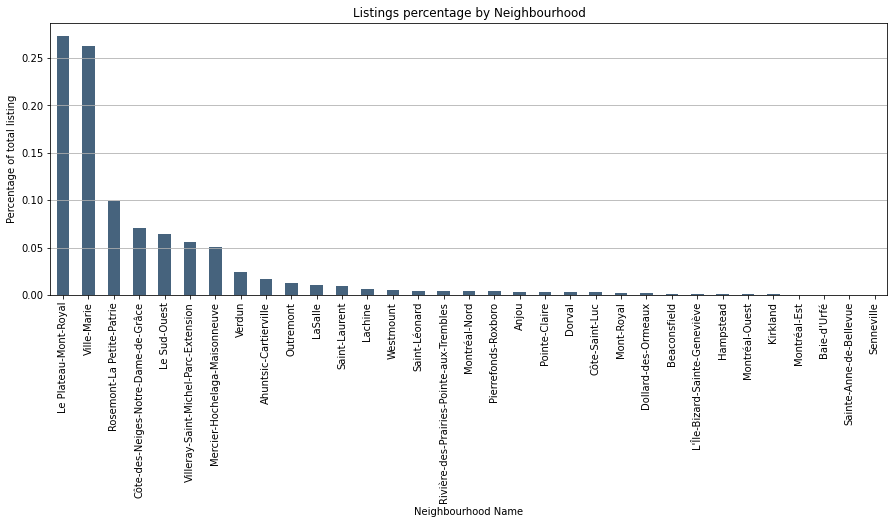

In [8]:
# Get listings by neighbourhood
cat_nhood = df['neighbourhood_cleansed'].value_counts()
cat_nhood_perc = cat_nhood/df.shape[0]

cat_nhood_plot = cat_nhood_perc.plot(kind="bar",figsize=(15,5),
                                            color='#46637D',
                                           title ="Listings percentage by Neighbourhood");
cat_nhood_plot.set_xlabel('Neighbourhood Name')
cat_nhood_plot.set_ylabel('Percentage of total listing')
cat_nhood_plot.grid('off', axis='y' )

We can see from the daigram above that 2 neighbourhoods account for more than 50% of the listings in Montréal. These 2 are central areas that are well serviced by public transportation.

## Listings by Room Type

In [9]:
# Check for missing data. If answer is 1.0, there is no missing data.
df['room_type'].count()/len(df['room_type'])


1.0

In [10]:
room_type = df['room_type'].value_counts()
room_type

Entire home/apt    14311
Private room        5604
Shared room          201
Hotel room            60
Name: room_type, dtype: int64

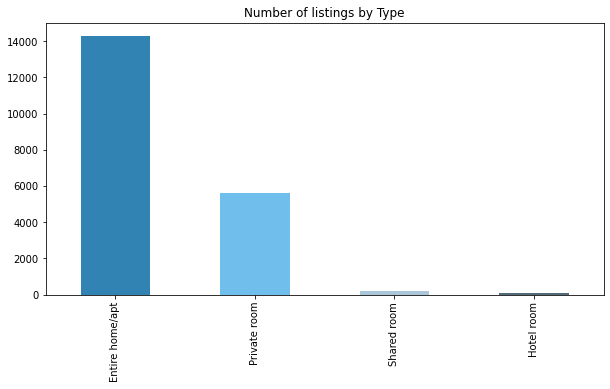

In [13]:
room_type_plot = room_type.plot(kind="bar",figsize=(10,5),
                                            color=['#3083B3','#70BEEB','#A9C7D9','#526B7A'], title ="Number of listings by Type"
)

Text(0, 0.5, 'Room Type')

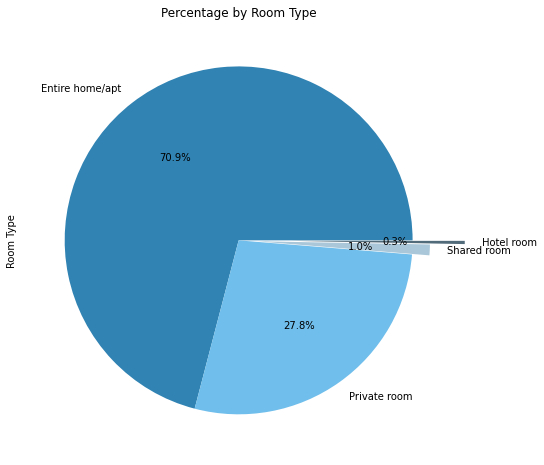

In [14]:
room_type_perc = room_type/df.shape[0]
room_type_pie = room_type_perc.plot.pie(figsize=(8,8),autopct='%1.1f%%',
                                        explode=(0, 0, 0.1,0.3),colors = ['#3083B3','#70BEEB','#A9C7D9','#526B7A'],
                                        title='Percentage by Room Type'
                                       )
room_type_pie.set_ylabel('Room Type')


## Listing By Room Type for the 3 major neighbourhoods

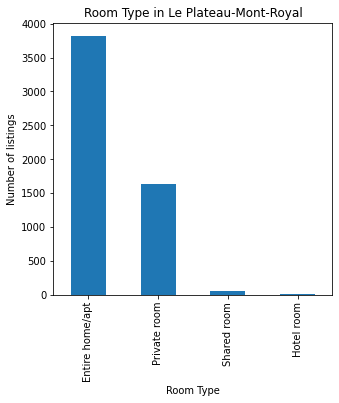

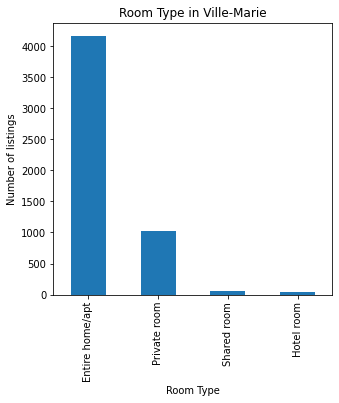

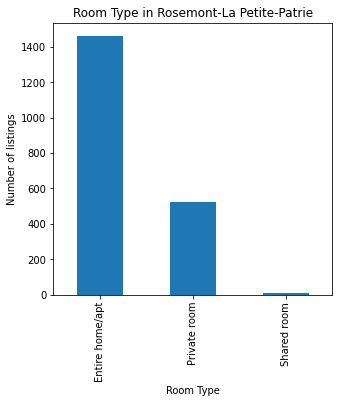

In [15]:
def plot_room_type_nhood(nhood_list):
    """Plots the number of units of each type for the first major neihbourhoods."""
    for nhood in nhood_list:
        df_major_nhood = df[
            df['neighbourhood_cleansed'].isin(
            [nhood]
            ) 
        ]
        x = df_major_nhood['room_type'].value_counts().reset_index()
        x.rename(columns={'index': 'room_type', 'room_type': 'count'}, inplace=True)
        x.set_index('room_type',inplace=True)
        plot = x.plot(kind='bar',legend=None,title=f'Room Type in {nhood}',figsize=(5,5))
        plot.set_xlabel('Room Type')
        plot.set_ylabel('Number of listings')

plot_room_type_nhood(['Le Plateau-Mont-Royal', 'Ville-Marie', 'Rosemont-La Petite-Patrie'])

## Predicting prices
First we will reduce the dimensions of the dataframe and check the missing values in each column

In [429]:
# Create a copy of the dataset and reduce its dimensions.
df_pred = df.copy()

# Location can be identified by the neighbhourhood and zip code, we don't need the 
clmns_pred_list =['host_is_superhost', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price','neighbourhood_cleansed',
                 ]
df_pred=df_pred[clmns_pred_list]

# Get percentage of no values in each column
print('Percentage of missing values in each column:\n')
for clmn in clmns_pred_list:
    perc = 1 - df_pred[clmn].count()/len(df_pred[clmn])
    print(f'{clmn}: {perc}')

Percentage of missing values in each column:

host_is_superhost: 0.00019825535289452745
room_type: 0.0
accommodates: 0.0
bathrooms: 0.0012390959555907965
bedrooms: 0.0015860428231562196
beds: 0.00718675654242662
square_feet: 0.9882533703409992
price: 0.0
neighbourhood_cleansed: 0.0


We can see from the above that square_fee has most of the data missing. Although it might be a good feature to predict the price we are going to drop it since we don't have enough data points. 

In [430]:
df_pred.drop(columns=['square_feet'],axis=1,inplace=True)
# We can likely safely drop the missing values in beds, bedrooms and bathrooms.
df_pred.dropna(subset=['beds','bedrooms','bathrooms','host_is_superhost'],axis=0,inplace=True)


We can double check that we haven't lost alot of points after dropping the missing values in each column

In [431]:
# percentage of data points and number of data points dropped from rows.
print(
    f'Percentage of original data after dropping: {df_pred.shape[0]/df.shape[0]}\n'
    f'Number of data points dropped: {df.shape[0] - df_pred.shape[0]}\n'
    f'Percentage of data dropped from original dataframe : {(df.shape[0] - df_pred.shape[0])/df.shape[0]}'
)

Percentage of original data after dropping: 0.9907315622521808
Number of data points dropped: 187
Percentage of data dropped from original dataframe : 0.009268437747819191


We need to check the datatypes of the columns to make sure they are in the right type and create dummies for the categorical columns to feed that to a linear regression predictive model.

In [432]:
# Check dtypes
df_pred.dtypes

host_is_superhost          object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
price                     float64
neighbourhood_cleansed     object
dtype: object

In [433]:
#Update host_is_superhost to a vector of zeros and one instead of string of 'f' and 't'
df_pred['host_is_superhost']= df_pred['host_is_superhost'].apply(lambda x: 0 if x == 'f' else 1)

In [434]:
df_pred.rename({'neighbourhood_cleansed':'nhood'},inplace=True)


Before creating dummies, lets check first the Probably Density Function(PDF) of the 'price' vector. The expectation is that the prices would be close to a normal distribution.

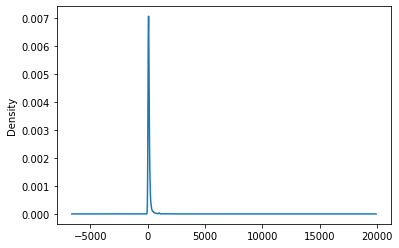

In [435]:
df_pred['price'].plot.kde()

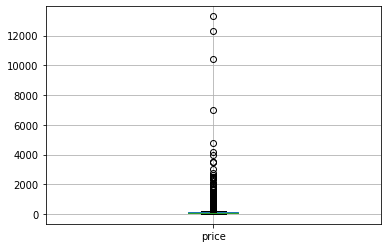

In [436]:
df_pred.boxplot(column=['price'])

It is clear from the boxplot above that we have:
* outliers or extreme cases.
* And possibly inbalance in data points between private/entire_house entries to prive_rooms

Let's check the min, max and median values as well as the 75 and 25 quartiles. 
it is abvious that there are some extreme values that don't make sense necessarily (an Airbnb for 13295.00$ does not make much sense). 

In [437]:
q1 = df_pred['price'].quantile(0.25)
median = df_pred['price'].quantile(0.50)
q2 = df_pred['price'].quantile(0.75)
print(f'Q1: {q_25}, median:{median} and Q3: {q2}')
print('-'*10)
max_price = df_pred['price'].max()
min_price = df_pred['price'].min()
print(
    f'Max price is: {max_price}\n'
    f'Min price is: {min_price}\n'
     )

Q1: 49.0, median:79.0 and Q3: 120.0
----------
Max price is: 13295.0
Min price is: 10.0



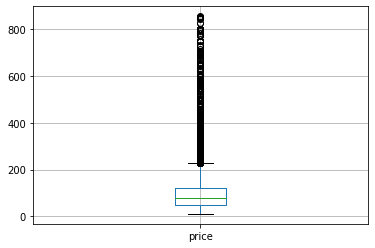

In [438]:
df_reduced = df_pred[df_pred['price']< 900]
df_reduced.boxplot(column=['price'])

In [423]:
# We can pick random 'threshold' points to see how much values do we have above that.
def check_threshold(threshold_lists,sign='greater'):
    for threshold in threshold_lists:
        if sign == 'greater':
            values = df_pred['price'].where(lambda x: x > threshold)
        else:
            values = df_pred['price'].where(lambda x: x < threshold)
            
        print(f'There are {values.count()} listings that are greater than {threshold}$')
        
check_threshold([1000,1500, 2000, 3000, 4000, 5000])

There are 93 listings that are greater than 1000$
There are 47 listings that are greater than 1500$
There are 25 listings that are greater than 2000$
There are 10 listings that are greater than 3000$
There are 6 listings that are greater than 4000$
There are 4 listings that are greater than 5000$


Let's hope that the super expensive listings are for an altra luxrious entire house listing or a golden hotel room with golden toilet seats ( a presidential listing in a presidential hotel tower). 

Lets look at the different room types separately, mainly private_rooms and entier houses 

In [424]:
# private_room = 'Private room'
# entire_house = 'Entire home/apt'
# df_private_room = df_pred[df_pred['room_type']== entire_house]
# df_private_room['price'].plot.kde()
# df_pred = df_pred[df_pred['room_type']== entire_house]
df_pred['price'].quantile(0.75)


120.0

In [425]:
df_pred = pd.get_dummies(df_pred, prefix_sep='_', dummy_na=False,drop_first=True) 
df_pred.head(5)


,host_is_superhost,accommodates,bathrooms,bedrooms,beds,price,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_cleansed_Anjou,neighbourhood_cleansed_Baie-d'Urfé,neighbourhood_cleansed_Beaconsfield,neighbourhood_cleansed_Côte-Saint-Luc,neighbourhood_cleansed_Côte-des-Neiges-Notre-Dame-de-Grâce,neighbourhood_cleansed_Dollard-des-Ormeaux,neighbourhood_cleansed_Dorval,neighbourhood_cleansed_Hampstead,neighbourhood_cleansed_Kirkland,neighbourhood_cleansed_L'Île-Bizard-Sainte-Geneviève,neighbourhood_cleansed_LaSalle,neighbourhood_cleansed_Lachine,neighbourhood_cleansed_Le Plateau-Mont-Royal,neighbourhood_cleansed_Le Sud-Ouest,neighbourhood_cleansed_Mercier-Hochelaga-Maisonneuve,neighbourhood_cleansed_Mont-Royal,neighbourhood_cleansed_Montréal-Est,neighbourhood_cleansed_Montréal-Nord,neighbourhood_cleansed_Montréal-Ouest,neighbourhood_cleansed_Outremont,neighbourhood_cleansed_Pierrefonds-Roxboro,neighbourhood_cleansed_Pointe-Claire,neighbourhood_cleansed_Rivière-des-Prairies-Pointe-aux-Trembles,neighbourhood_cleansed_Rosemont-La Petite-Patrie,neighbourhood_cleansed_Saint-Laurent,neighbourhood_cleansed_Saint-Léonard,neighbourhood_cleansed_Sainte-Anne-de-Bellevue,neighbourhood_cleansed_Senneville,neighbourhood_cleansed_Verdun,neighbourhood_cleansed_Ville-Marie,neighbourhood_cleansed_Villeray-Saint-Michel-Parc-Extension,neighbourhood_cleansed_Westmount
0,0,2,1.0,1.0,1.0,39.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,1.0,1.0,1.0,30.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,4,1.0,1.0,1.0,175.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,4,1.0,1.0,2.0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,5,1.0,2.0,2.0,145.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [426]:
X = df_pred.drop('price',axis=1)
y = df_pred['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=96) 

In [427]:
linear_model = LinearRegression(normalize=True)
linear_model.fit(X_train,y_train)

y_hat_test = linear_model.predict(X_test)
y_hat_train = linear_model.predict(X_train)
test_score = r2_score(y_test, y_hat_test )
train_score = r2_score(y_train, y_hat_train)
print(test_score,train_score)

0.16309691619195588 0.11663025648367142


In [428]:
linear_model.coef_

array([-3.02673522e-02,  1.66478171e+01,  5.30549531e+01, -2.24213896e+00,
        1.20469292e+01,  4.39646618e+01, -2.34597227e+01, -5.44150535e+01,
       -1.43454555e+01,  2.04698689e+02, -3.87552038e+01,  1.15389058e+01,
        1.38532587e+01, -2.52420244e+01,  1.36928172e+02,  8.17978527e+01,
        1.87890954e+01, -2.54823785e+00, -1.02924076e+01, -3.22316979e+01,
        2.22797652e+01,  2.13778895e+01, -3.40176204e+00,  1.75709315e+02,
        1.73788423e+01, -5.82939056e+00, -6.08730027e+00,  2.56420283e+01,
       -1.30042051e+01, -3.48119469e+00,  2.47974048e-01,  1.52832827e+01,
        1.44738249e+01,  2.18864550e+01, -1.56521520e+01,  1.57863878e+00,
       -4.41529501e+00,  3.72519854e+01,  9.62507302e+00,  6.36337087e+01])